In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.options.display.float_format = '{:.2f}'.format

from model_SARIMA import *
from model_naiv import build_naive_model
from test_mean import t_test, wilcoxon_test, binomial_test, kolmogorov_test
from test_correlation import *
from test_normal import hist_plot
from time_series import *
from cross_validation import *


warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

1 Store wählen

In [3]:
# Filtern nach Store
store_number = 2
store = df[df['store'] == store_number].copy()

# Datum als Index setzen
store.set_index('date', inplace=True)

# Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

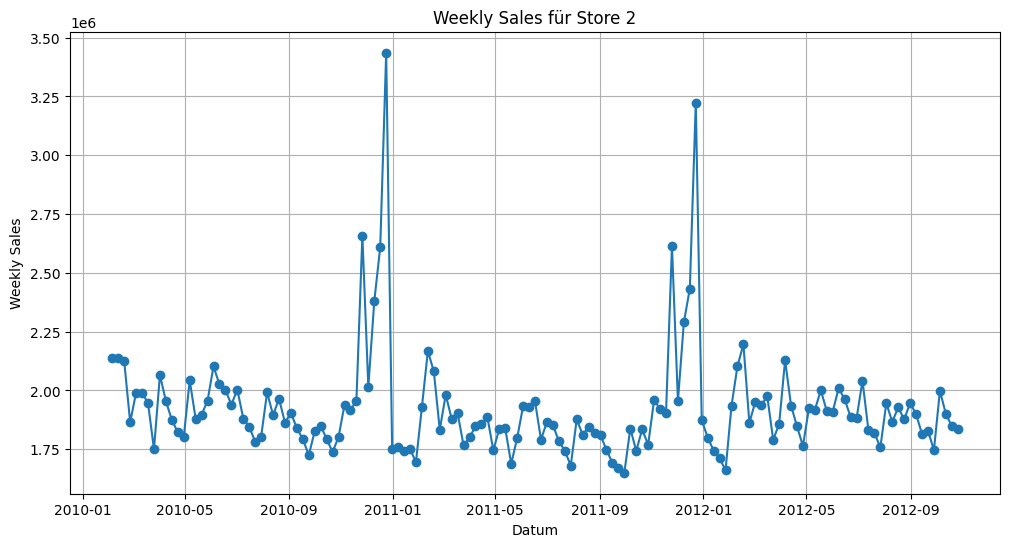

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Weekly Sales für Store {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

Seasonal

In [5]:
#seasonal_plot(sales)
#seasonal_subseries_plot(sales)
#acf_plot(sales)
#lag_plot(sales)
#decompose(sales)

Modell wählen

In [6]:
#model_type = 'SARIMA'
model_type = 'Naive'

Residuen und Fitted Values berechnen

In [7]:
if model_type == 'Naive':
    resid, fitted_values = build_naive_model(sales)

if model_type == 'SARIMA':
    sarima_params  = optimal_orders_5.get(str(store_number))
    order = tuple(sarima_params["order"])
    seasonal_order = tuple(sarima_params["seasonal_order"])

    sarima_model = build_SARIMA(sales, order = order, seasonal_order = seasonal_order)
    resid = sarima_model.resid.iloc[1:]
    fitted_values = sarima_model.fittedvalues.iloc[1:]
    sarima_model.summary()

Plot

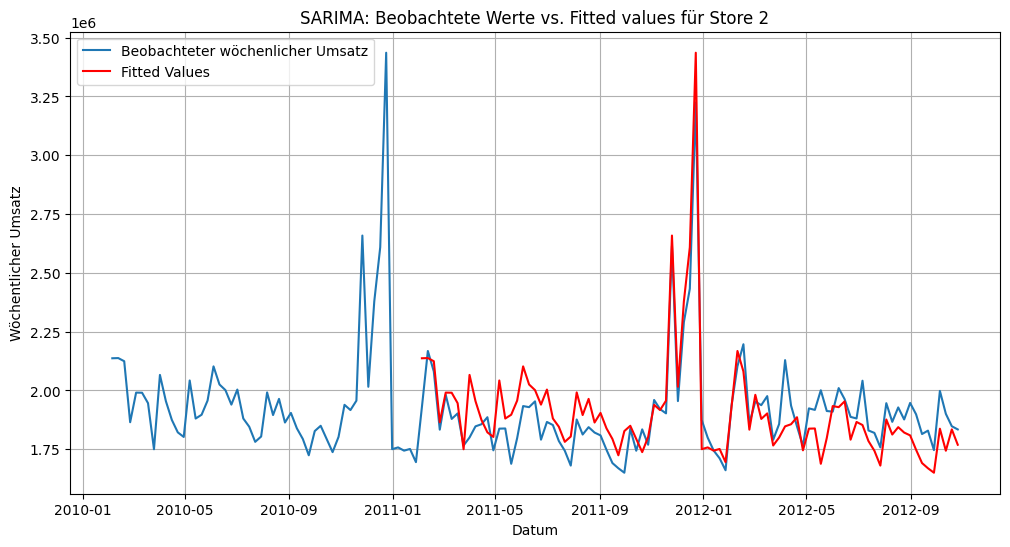

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Fitted Values')
plt.title('SARIMA: Beobachtete Werte vs. Fitted values für Store {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.show()


Korrelations Tests

Box Pierce Test
p-Wert an lag 29: 0.0000
p-Wert Median: 3.520622348237227e-40

Ljung Box Test
p-Wert an lag 29: 0.0000
p-Wert Median: 2.974948939067503e-45

Monti Test: 0.0000
Fisher Test: 0.0000
Breusch Godfrey: 0.0000
Run Test: 0.0000
Durbin Watson: 0.9198


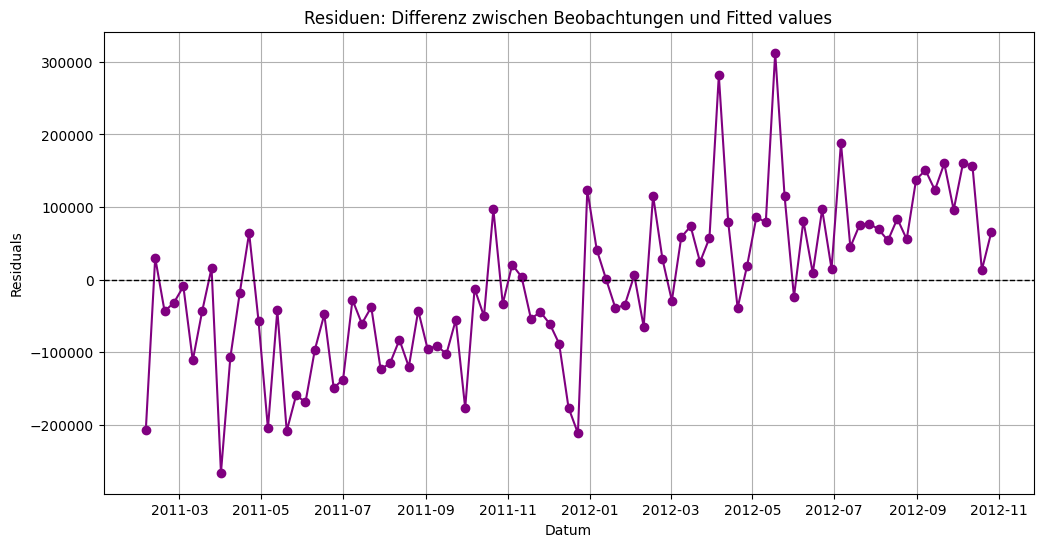

<Figure size 1200x600 with 0 Axes>

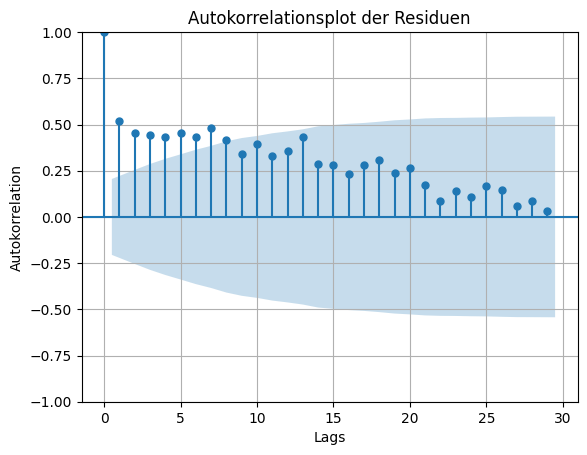

In [9]:
box_pierce_test(residuals = resid, store_num = store_number, model = model_type, lags = 29)
ljung_box_test(residuals = resid, store_num = store_number, model = model_type, lags = 29)
monti_test(residuals = resid, store_num = store_number, model = model_type, m = 29)
fisher_test(residuals = resid, store_num = store_number, model = model_type, m = 4)

if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 29)
if model_type == 'Naive':
    breusch_godfrey_test_naive(sales, lags = 5)

run_test(residuals = resid)

durbin_watson_test(residuals = resid)

residual_plot(resid)

acf_resid_plot(resid, lags = 29)


Mittelwert Tests

Mittelwert der Residuen: -6109.2062
T-Test: 0.5930
Wilcoxon Test: 0.5986
Binomial Test: 0.8341
Kolmogorov Test: 0.9361


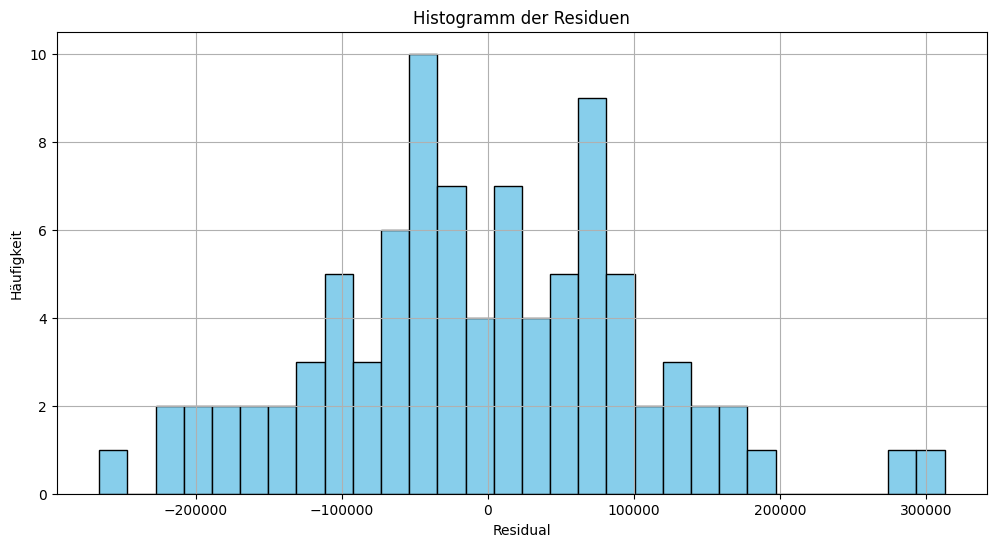

In [10]:
print(f"Mittelwert der Residuen: {resid.mean():.4f}")


t_test(resid)
wilcoxon_test(resid)
binomial_test(resid)
kolmogorov_test(resid)

hist_plot(resid)


SMAPE

In [11]:
numerator = np.abs(fitted_values - sales.iloc[1:])
denominator = (np.abs(fitted_values) + np.abs(sales.iloc[1:])) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: nan%


Kreuz Validierung

Seasonal Naive Model Cross-Validation RMSE (period=52): 105559.68622920438


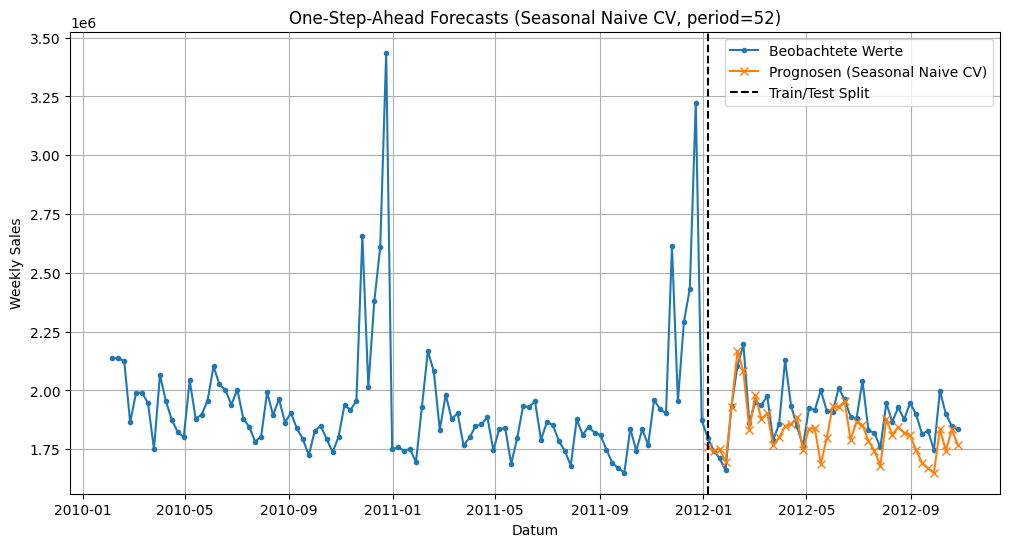

In [12]:
if model_type == 'SARIMA':
    cv_df, train_size = cross_validation_SARIMA(sales, order = order, seasonal_order = seasonal_order)
if model_type == 'Naive':
    cv_df = cross_validation_naive(sales)


Korrelations Tests

Box Pierce Test
p-Wert an lag 29: 0.9916
p-Wert Median: 0.7694436641160773

Ljung Box Test
p-Wert an lag 29: 0.8837
p-Wert Median: 0.570243850114478

Monti Test: 0.0000
Fisher Test: 0.0000
Breusch Godfrey: 0.0000
Run Test: 0.7602
Durbin Watson: 0.8675


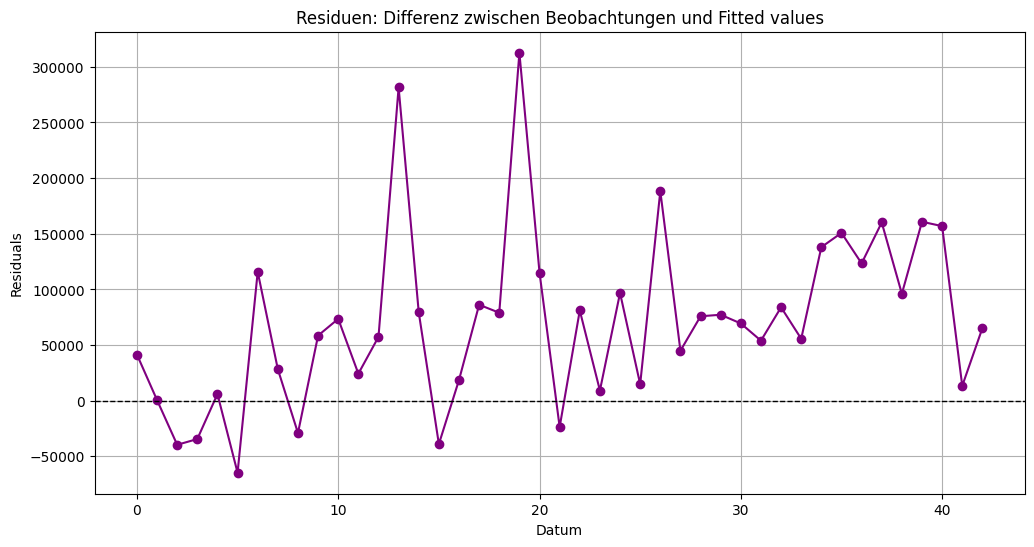

<Figure size 1200x600 with 0 Axes>

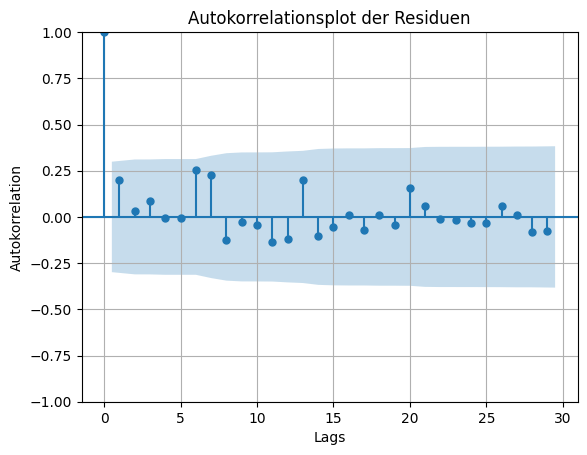

In [14]:
errors = cv_df['error']

box_pierce_test(residuals = errors, store_num = store_number, model = model_type, lags = 29)
ljung_box_test(residuals = errors, store_num = store_number, model = model_type, lags = 29)
monti_test(residuals = errors, store_num = store_number, model = model_type, m = 21)
fisher_test(residuals = errors, store_num = store_number, model = model_type, m = 4)

if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 29) #TODO: Gleich wie in-sample?
if model_type == 'Naive':
    breusch_godfrey_test_naive(sales, lags = 5)


run_test(residuals = errors)

durbin_watson_test(residuals = errors)

residual_plot(residuals = errors)
acf_resid_plot(residuals = errors)


Mittelwert Tests

Mittelwert der Errors: 9757.892705818123
T-Test: 0.4103
Wilcoxon Test: 0.6888
Binomial Test: 1.0000
Kolmogorov Test: 0.7131


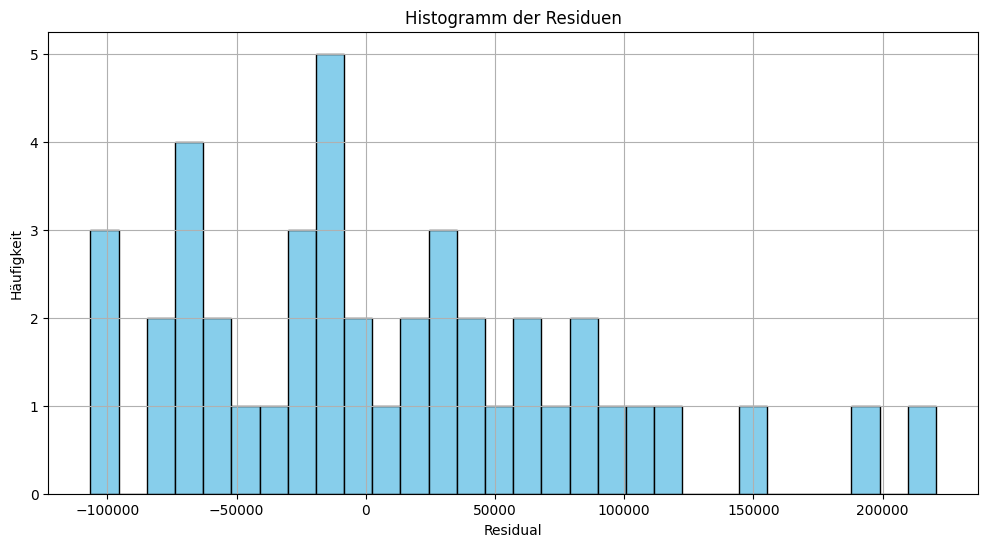

In [ ]:
print(f'Mittelwert der Errors: {errors.mean()}')

t_test(errors)
wilcoxon_test(errors)
binomial_test(errors)
kolmogorov_test(errors)

hist_plot(errors)


SMAPE

In [ ]:
actual_values = cv_df['actual']
forecast_values = cv_df['forecast']

numerator = np.abs(forecast_values - actual_values)
denominator = (np.abs(forecast_values) + np.abs(actual_values)) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: 3.14%
